In [36]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [37]:
from clawpack.pyclaw import Solution
import yt


In [38]:
def load_yt(frame):
    """
    Load a frame of amrclaw data and reformat for yt.
    """
    sol = Solution(frame,path='_output',file_format='ascii')
    grid_data = []
    bbox = []
     
    for state in sorted(sol.states, key = lambda a: a.patch.level):
        patch = state.patch
        #print patch
        #print state
        #print patch.level
        d = {
            'left_edge': patch.lower_global,
            'right_edge': patch.upper_global,
            'level': patch.level-1,
            'dimensions': patch.num_cells_global,
            ('gas','rho'): state.q[0,...],#format:  ('field tyep', 'field name'): ndarray
            ('gas','velocity_x') : state.q[1,...]/state.q[0,...],
            ('gas','velocity_y'): state.q[1,...]/state.q[0,...],
            ('gas','velocity_z'): state.q[1,...]/state.q[0,...],
            ('gas','E'): state.q[4,...],            
            'number_of_particles': 0
            }
        grid_data.append(d)
        bbox = np.vstack((sol.patch.lower_global,sol.patch.upper_global)).T
    bbox = np.vstack((sol.domain.patch.lower_global,sol.domain.patch.upper_global)).T#from base patch
    field_units = {('gas','rho'): 'kg/m^3',('gas','velocity_x'): 'm/s'}
    ds = yt.load_amr_grids(grid_data, sol.patch.num_cells_global, field_units=field_units, length_unit='m', sim_time=sol.state.t, bbox=bbox)
    return ds

In [39]:
ds = load_yt(4)

yt : [INFO     ] 2016-03-27 14:07:51,143 Parameters: current_time              = 2.0
yt : [INFO     ] 2016-03-27 14:07:51,143 Parameters: domain_dimensions         = [20 20 20]
yt : [INFO     ] 2016-03-27 14:07:51,144 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2016-03-27 14:07:51,144 Parameters: domain_right_edge         = [ 2.  2.  2.]
yt : [INFO     ] 2016-03-27 14:07:51,144 Parameters: cosmological_simulation   = 0.0


In [40]:
print ds.field_list
print ds.field_units #todo: figure out how to change field units in ds

yt : [INFO     ] 2016-03-27 14:07:51,173 Loading field plugins.
yt : [INFO     ] 2016-03-27 14:07:51,173 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-03-27 14:07:51,174 Loaded astro (15 new fields)
yt : [INFO     ] 2016-03-27 14:07:51,174 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-03-27 14:07:51,175 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-03-27 14:07:51,175 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-03-27 14:07:51,176 Loaded geometric (112 new fields)
yt : [INFO     ] 2016-03-27 14:07:51,176 Loaded local (112 new fields)
yt : [INFO     ] 2016-03-27 14:07:51,176 Loaded magnetic_field (120 new fields)
yt : [INFO     ] 2016-03-27 14:07:51,177 Loaded my_plugins (120 new fields)
yt : [INFO     ] 2016-03-27 14:07:51,177 Loaded species (122 new fields)


[('gas', 'velocity_y'), ('gas', 'E'), ('gas', 'velocity_x'), ('gas', 'rho'), ('gas', 'velocity_z')]
{}


## Data inspection

In [41]:
#This shows that we have loaded AMR patches of all levels
#Simulation time is also known to the dataset of yt
ds.print_stats() #todo: what are the four units (Mpc, pc, AU, cm) in output of this function?


level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	     1	          8000	            20
  1	     8	         64000	            40
  2	   251	        258472	            64
----------------------------------------------
   	   260	        330472


t = 2.00000000e+00 = 2.00000000e+00 s = 6.33761756e-08 years

Smallest Cell:
	Width: 8.102e-25 Mpc
	Width: 8.102e-19 pc
	Width: 1.671e-13 AU
	Width: 2.500e+00 cm


# start plotting

In [42]:
print "Lower corner: ",ds.domain_left_edge
print "Upper corner: ",ds.domain_right_edge
print "cells: ", ds.domain_dimensions

Lower corner:  [ 0.  0.  0.] code_length
Upper corner:  [ 2.  2.  2.] code_length
cells:  [20 20 20]


yt : [INFO     ] 2016-03-27 14:07:51,923 xlim = 0.000000 2.000000
yt : [INFO     ] 2016-03-27 14:07:51,923 ylim = 0.000000 2.000000
yt : [INFO     ] 2016-03-27 14:07:51,924 xlim = 0.000000 2.000000
yt : [INFO     ] 2016-03-27 14:07:51,925 ylim = 0.000000 2.000000
yt : [INFO     ] 2016-03-27 14:07:51,925 Making a fixed resolution buffer of (('gas', 'rho')) 800 by 800
yt : [INFO     ] 2016-03-27 14:07:52,062 Min Value is 8.95395e-01 at 0.9250000000000000 0.0250000000000000 0.0250000000000000
yt : [INFO     ] 2016-03-27 14:07:52,084 Max Value is 2.17140e+00 at 0.0875000000000000 0.0875000000000000 0.0625000000000000
yt : [INFO     ] 2016-03-27 14:07:52,088 Making a fixed resolution buffer of (('gas', 'rho')) 800 by 800



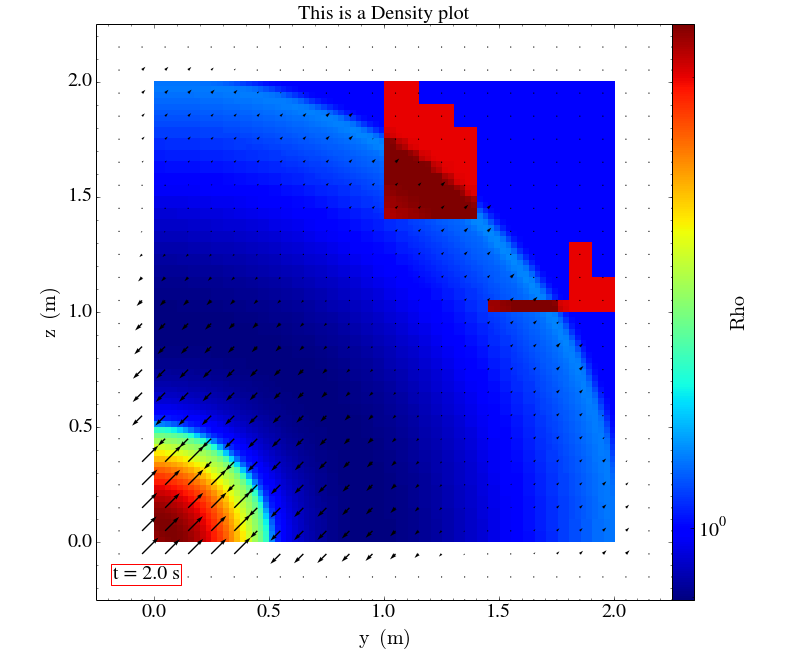

In [43]:
#The slice will be perpendicular to x-axis and centered at [0.1, 1. 1.] (point [0.1, 1., 1.] is on the slice)
#by default, SlicePlot shifts the coordinates on the axes such that the origin is at the center of the slice.
#To instead use the coordinates as defined in the dataset, use the optional argument: origin="native"
s = yt.SlicePlot(ds, "x",['rho'], center=[0.1,1.,1.], origin="native",fontsize=20)

s.set_cmap("rho", "jet")
#s.set_cbar_minorticks('rho','on')
#s.set_minorticks('rho','on')

#set the scale of the colormap dynamically
zmin = ds.find_min(('gas','rho'))[0].value
zmax = ds.find_max(('gas','rho'))[0].value
s.set_zlim("rho", zmin, zmax)#set_zlim(field, zmin, zmax) 

#s.annotate_clear()#clear previous annotations

#any other plots can be overlaid
#For details, see http://yt-project.org/docs/dev/visualizing/callbacks.html#callbacks

#draw velocity quiver
#these two methods do the same job
#s.annotate_velocity()

s.annotate_quiver(('gas','velocity_x'),('gas','velocity_y'),30, scale=0.1, scale_units='inches',normalize=False) 
#scale is the data units per arrow length unit using scale_units
#s.annotate_quiver(('gas','velocity_x'),('gas','velocity_y'),30, normalize=True) 



#draw boundary of AMR grid
#s.annotate_grids(min_level=0,max_level=0, draw_ids=True, edgecolors='w', linewidth=1.0)
s.annotate_title('This is a Density plot')

#add current time
s.annotate_timestamp(corner='lower_left',draw_inset_box=True,
                     text_args={'color':'black'},inset_box_args={'facecolor':'white','edgecolor':'red'})

#todo: figure out how to plot mesh cells in patches of specific levels
from yt.units import m #using meter as the unit
s.set_width((2.5*m, 2.5*m)) # set the width of the plot in x and y direction



### todo: how can I make it to show more colorbar labels?
### todo: it seems that the colorbar is using log scale
### todo: there is a patch of probably wrong color (yellow) in the middle of the figure 

In [44]:
s.save('euler')

yt : [INFO     ] 2016-03-27 14:07:52,345 Saving plot euler_Slice_x_rho.png


['euler_Slice_x_rho.png']

In [45]:
print zmin
print zmax

0.895395147306
2.17139770384


In [46]:
#we can browse data in ds in this way
ad = ds.all_data()
rho_ytarray = ad['gas','rho']
#rho_ytarrayis a YTarray object which inherits from numpy ndarray object